#### 1. Importing all the libraries

In [17]:
import pandas as pd
import numpy as np
import os
import shutil
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import sys
from sklearn.model_selection import cross_val_score
from sklearn import metrics
from sklearn import tree
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

#### 2. Define the Functions

In [18]:
# Function that create the episode data - sample randomaly
def get_data(episode_size,policy,mode):
    global dataset
    if mode=='train':
        if policy==0:
             dataset=data.sample(n=episode_size)
        else:
            dataset=data
    else:
        dataset = pd.read_csv(location + '/' + file +'_test_int.csv', index_col=0)
    return dataset

In [19]:
# Function that separate the episode data into features and label
def data_separate (dataset):
    global X
    global y    
    X = dataset.iloc[:,0:dataset.shape[1]-1]  # all rows, all the features and no labels
    y = dataset.iloc[:, -1]  # all rows, label only
    return X,y

In [20]:
# Function that split the episode data into train and test
def data_split(X,y):
    global X_train_main
    global X_test_main   
    global y_train
    global y_test  
    from sklearn.model_selection import train_test_split
    X_train_main, X_test_main, y_train, y_test = train_test_split(X,y,test_size=0.2,random_state=4)
    return X_train_main, X_test_main, y_train, y_test

In [21]:
# Function that chooses exploration or explotation method
def exploration_explotation(epsilon):
    global exploration 
    if np.random.rand() < epsilon:  
        exploration=1
    else:
        exploration=0    
    return exploration

In [22]:
# Function that returns all available actions in the state given as an argument: 
def available_actions(number_of_columns,columns,initial_state,current_state,trashold, exploration):
    global exclude
    global all_columns
#    exclude=[]
    all_columns=np.arange(number_of_columns+1)
    # remove columns that have been already selected
    exclude=columns.copy()
    # remove the initial_state and the current_state
    exclude.extend([initial_state, current_state])
    available_act = list(set(all_columns)-set(exclude))
    # remove actions that have negetiv Q value
    if exploration==0:
        index = np.where(Q[current_state,available_act] > trashold)[1]
        available_act= [available_act[i] for i in index.tolist()]
    return available_act

In [23]:
def sample_next_action(current_state, Q, available_act, exploration):
    global available_act_q_value
    available_act_q_value = [float(q) for q in np.array(Q[current_state, available_act]).reshape(-1)]
    
    if exploration == 1: 
        # Random selection
        next_action = int(np.random.choice(available_act, 1).item())
    else: 
        # Greedy selection according to max value
        maxQ = max(available_act_q_value)
        count = available_act_q_value.count(maxQ)
        
        if count > 1:
            max_columns = [i for i in range(len(available_act_q_value)) if available_act_q_value[i] == maxQ]
            i = int(np.random.choice(max_columns, 1).item())
        else:
            i = available_act_q_value.index(maxQ)
        
        next_action = available_act[i]  
    
    return next_action


In [24]:
# function that update a list with all selected columns in the episode
def update_columns(action, columns):
    update_columns=columns
    update_columns.append(action)
    return update_columns

In [25]:
# function that update the X_train and X_test according to the current episode columns list 
def update_X_train_X_test(columns,X_train_main, X_test_main):
    X_train=X_train_main.iloc[:,columns]
    X_test=X_test_main.iloc[:,columns]
    X_train=pd.DataFrame(X_train)
    X_test=pd.DataFrame(X_test)
    return X_train, X_test

In [26]:
# Function that run the learner and get the error to the current episode columns list
def Learner(X_train, X_test,y_train, y_test):
    global learner
    global y_pred
    if learner_model == 'DT':
        learner = tree.DecisionTreeClassifier()
        learner = learner.fit(X_train, y_train)
        y_pred = learner.predict(X_test)
    elif learner_model == 'KNN':
        learner = KNeighborsClassifier(metric='hamming',n_neighbors=5)
        learner = learner.fit(X_train, y_train)
        y_pred = learner.predict(X_test)        
    elif learner_model == 'SVM':
        learner = SVC()
        learner = learner.fit(X_train, y_train)
        y_pred = learner.predict(X_test)        
    elif learner_model == 'NB':
        learner = MultinomialNB()
        learner = learner.fit(X_train, y_train)
        y_pred = learner.predict(X_test)
    elif learner_model == 'AB':
        learner = AdaBoostClassifier()
        learner = learner.fit(X_train, y_train)
        y_pred = learner.predict(X_test)  
    elif learner_model == 'GB':
        learner = GradientBoostingClassifier()
        learner = learner.fit(X_train, y_train)
        y_pred = learner.predict(X_test)  
    accuracy=metrics.accuracy_score(y_test, y_pred)
    error=1-accuracy
    return error

In [27]:
def q_update(current_state, action, learning_rate, reward):
    # next_state = current action
    max_index = np.where(Q[action,] == np.max(Q[action,]))[0]  # Use [0] instead of [1] for 1D arrays
    
    if max_index.shape[0] > 1:
        # Resolve tie by selecting one randomly
        max_index = int(np.random.choice(max_index, size=1).item())
    else:
        max_index = int(max_index[0])  # Convert the first element to a scalar

    max_value = Q[action, max_index]

    # Update the Q matrix
    if Q[current_state, action] == 1:
        Q[current_state, action] = learning_rate * reward
    else:
        Q[current_state, action] = Q[current_state, action] + learning_rate * (
            reward + (discount_factor * max_value) - Q[current_state, action]
        )


### Experiment mangment

#### 3. Define the parameters 

In [28]:
## for run time ##
N_features=5
N_data=1
## for run time ##

#Experiment: 
experiment='test'
number_of_experiment=1

# Dataset parameters #
location = 'Datasets/adult'
outputlocation='Datasets'
file='adult' #adult #diabetic_data #no_show
#np.random.seed(3)

# Q learning parameter # 
learning_rate=0.005
discount_factor = 0.01 #0
epsilon = 0.1

# Learner and episode parameters #
learner_model = 'DT' #DT #KNN #SVM
episode_size=100
internal_trashold=0
external_trashold=0
filename= file +'_int.csv'

#Experiments folder management: 
#if not os.path.exists('/Experiments'):
#    os.makedirs('/Experiments') 
if not os.path.exists('Experiments/'+ str(experiment)):
    os.makedirs('Experiments/'+ str(experiment))
else:
    shutil.rmtree('Experiments/'+ str(experiment))          #removes all the subdirectories!
    os.makedirs('Experiments/'+ str(experiment))
#writer = pd.ExcelWriter('Experiments/'+ str(experiment) + '/df.xlsx') 



text_file = open('Experiments/'+ str(experiment) +'/parameters.txt', "w")
text_file.write('experiment: ' + str(experiment)+ '\n')
text_file.write('number of experiments: ' + str(number_of_experiment)+ '\n')
text_file.write('file: ' + str(file)+ '\n')
text_file.write('learner model: ' + str(learner_model)+ '\n')
text_file.write('episode size: ' + str(episode_size)+ '\n')
#text_file.write('numbers of epocs: ' + str(epocs)+ '\n')
text_file.write('internal trashold: ' + str(internal_trashold)+ '\n')
text_file.write('external trashold: ' + str(external_trashold)+ '\n')
 
text_file.close()

#### 4. Run all experiments

Experiments 0 start
number of columns: 5 (exclude class column)
Number of episodes: 2443.0
initial state number: 5 (the last dummy column we have created)
episode 1 start
episode columns: [np.int64(3), 2, np.int64(1), 0, 4] epsilon: 0.9 learning rate: 0.09 error: 0.19999999999999996
episode policy:[np.int64(2), np.int64(4), np.int64(3), np.int64(0), np.int64(1)] train accuracy: 0.822144903806795 test accuracy: 0.7863720073664825
episode 1 end
episode 2 start
episode columns: [np.int64(1), 2, 4, np.int64(3), 0] epsilon: 0.9 learning rate: 0.09 error: 0.19999999999999996
episode policy:[np.int64(4), np.int64(0), np.int64(1), np.int64(3)] train accuracy: 0.8022922636103151 test accuracy: 0.7937384898710865
episode 2 end
episode 3 start
episode columns: [3, np.int64(4), 0, 2, 1] epsilon: 0.9 learning rate: 0.09 error: 0.30000000000000004
episode policy:[np.int64(2), np.int64(3), np.int64(1), np.int64(4), np.int64(0)] train accuracy: 0.8225542365943512 test accuracy: 0.7845303867403315
epis

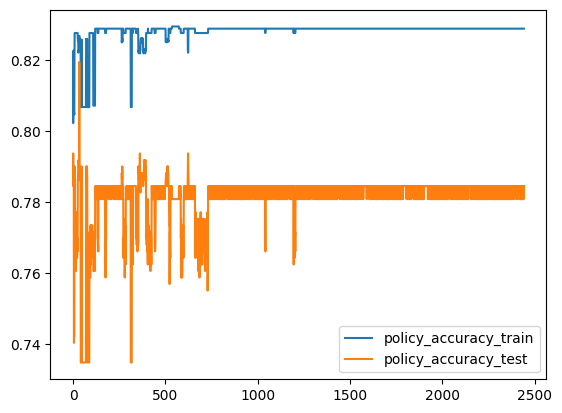

In [30]:
for e in range (number_of_experiment):
    if not os.path.exists('Experiments/'+ str(experiment)+ '/'+ str(e)):
        os.makedirs('Experiments/'+ str(experiment)+ '/'+ str(e))
    else:
        shutil.rmtree('Experiments/'+ str(experiment)+ '/'+ str(e))          #removes all the subdirectories!
        os.makedirs('Experiments/'+ str(experiment)+ '/'+ str(e))
    print ('Experiments ' + str(e) + ' start')
##########################Experiment setup##########################
    # Read the data
    data = pd.read_csv(location + '/' + filename, index_col=0)
    
##### for run time - start #####
    import timeit
    start = timeit.default_timer()
    size= int(N_data* len(data.index))
    data = data.sample(n=size)
    data=data.iloc[:,-N_features-1:]
##### for run time - end #####
    
    #Set the number of iterations:
    interations=10*len(data.index)/episode_size
    # Set the number of columns exclude the class column
    number_of_columns=data.shape[1]-1 
    print ("number of columns: "+ str(number_of_columns) +" (exclude class column)" ) 
    # Set the number of episodes 
    # episodes_number=epocs*len(data.index)/episode_size
    episodes_number=interations
    print ("Number of episodes: "+ str(episodes_number) ) 
    # Initialize matrix Q as a 1 values matrix:
    #Q = np.matrix(np.ones([number_of_columns+1,number_of_columns+1])) # we will use the last dummy columns as initial state s
    Q = np.matrix(np.ones([number_of_columns+1,number_of_columns+1])) # we will use the last dummy columns as initial state s
    # Set initial_state to be the last dummy column we have created
    initial_state=number_of_columns
    # define data frame to save episode policies results
    df = pd.DataFrame(columns=('episode','episode_columns','policy_columns','policy_accuracy_train','policy_accuracy_test'))
    print ("initial state number: "+ str(initial_state) + " (the last dummy column we have created)") 

    ##########################  episode  ##########################  
    for i in range (int(episodes_number)):
    ########## Begining of episode  ############
        # Initiate lists for available_act, episode_columns and and the policy mode & episode_error
        episode_available_act=list(np.arange(number_of_columns))
        episode_columns=[]
        policy=0
        episode_error=0
        # Initiate the error to 0.5
        episode_last_error=0.5
        # Initiate current_state to be initial_state
        episode_current_state=initial_state
        # Create the episode data 
        episode= get_data(episode_size, policy=0, mode='train')
        # Separate the episode data into features and label
        X_episode,y_episode=data_separate(episode)
        # Split the data into train and test 
        X_train_main_episode, X_test_main_episode, y_train_episode, y_test_episode = data_split(X_episode,y_episode)
        if i<episodes_number*0.25:
            epsilon=0.9
            learning_rate=0.09
        elif i<episodes_number*0.5:
            epsilon=0.5
            learning_rate=0.05
        elif i<episodes_number*0.75:
            epsilon=0.3
            learning_rate=0.01
        else:
            epsilon=0.1
            learning_rate=0.005
        ########## Q learning start ############

        while len(episode_available_act)>0:
            # Get exploration or explotation flag 
            exploration=exploration_explotation(epsilon)
            # Get available actions in the current state
            episode_available_act = available_actions(number_of_columns,episode_columns,initial_state,episode_current_state,internal_trashold,exploration)
            if len(episode_available_act)>0:
                # Sample next action to be performed
                episode_action = sample_next_action(episode_current_state, Q, episode_available_act, exploration)
                # Update the episode_columns
                episode_columns=update_columns(episode_action,episode_columns)
                # Update the dataset to include all episode columns + current selected action (column)
                X_train_episode, X_test_episode =update_X_train_X_test(episode_columns,X_train_main_episode, X_test_main_episode)
                # Update the accuracy of the current columns
                episode_error= Learner(X_train_episode, X_test_episode, y_train_episode, y_test_episode)
                # Update reward
                episode_reward=episode_last_error-episode_error
                # Update Q matrix
                q_update(episode_current_state,episode_action,learning_rate, episode_reward)
                # Update parameters for next round 
#                 if episode_current_state==initial_state:
#                     beta=abs(episode_reward-Q[episode_current_state,episode_action])
#                     epsilon=final_epsilon+(beta*(1-final_epsilon))
                #    learning_rate=final_learning_rate+(beta*(1-final_learning_rate))
                episode_current_state=episode_action
                episode_last_error=episode_error
                 
        ########## Q learning End ############

        #Save Q matrix: 
        if (i%100 ==0):
            Q_save=pd.DataFrame(Q)
            Q_save.to_csv('Experiments/'+ str(experiment)+ '/'+ str(e)+ '/Q.'+ str(i+1) + '.csv') 

        # Calculate policy 
        policy_available_actions=list(np.arange(number_of_columns))
        policy_columns=[]
        policy_current_state=initial_state
        while len(policy_available_actions)>0:
            # Get available actions in the current state
            policy_available_actions = available_actions(number_of_columns,policy_columns,initial_state,policy_current_state, external_trashold, exploration=0)
            # # Sample next action to be performed
            if len(policy_available_actions)>0:
                policy_select_action = sample_next_action(policy_current_state, Q, policy_available_actions, exploration=0)
                # Update the episode_columns
                policy_columns=update_columns(policy_select_action,policy_columns)
                policy_current_state=policy_select_action
        # Calculate policy_accuracy    
        if len(policy_columns)>0:
            ##for training dataset##
            policy_data=get_data(episode_size,policy=1,mode='train')
            X_policy,y_policy=data_separate(policy_data)
            X_train_main_policy, X_test_main_policy, y_train_policy, y_test_policy = data_split(X,y)
            X_train_policy, X_test_policy =update_X_train_X_test(policy_columns, X_train_main_policy, X_test_main_policy)
            policy_error=Learner(X_train_policy, X_test_policy,y_train_policy, y_test_policy)
            policy_accuracy_train=1-policy_error
            ##for testing dataset##
            policy_data=get_data(episode_size,policy=1,mode='test')
            X_policy,y_policy=data_separate(policy_data)
            X_train_main_policy, X_test_main_policy, y_train_policy, y_test_policy = data_split(X,y)
            X_train_policy, X_test_policy =update_X_train_X_test(policy_columns, X_train_main_policy, X_test_main_policy)
            policy_error=Learner(X_train_policy, X_test_policy,y_train_policy, y_test_policy)
            policy_accuracy_test=1-policy_error 
        else:
            policy_accuracy_train=0 
            policy_accuracy_test=0
        #df=df.append({'episode':str(i+1), 'episode_columns':str(episode_columns),'policy_columns':str(policy_columns),'policy_accuracy_train':policy_accuracy_train,'policy_accuracy_test':policy_accuracy_test}, ignore_index=True)
        #new_row = pd.DataFrame([{'episode': str(i+1),
        #                  'episode_columns': str(episode_columns),
        #                  'policy_columns': str(policy_columns),
        #                  'policy_accuracy_train': policy_accuracy_train,
        #                  'policy_accuracy_test': policy_accuracy_test}])
        #df = pd.concat([df, new_row], ignore_index=True)
        df.loc[len(df)] = {
            'episode': str(i+1),
            'episode_columns': str(episode_columns),
            'policy_columns': str(policy_columns),
            'policy_accuracy_train': policy_accuracy_train,
            'policy_accuracy_test': policy_accuracy_test
        }

        #Prints
        print ("episode "+ str(i+1) +" start") 
        print ("episode columns: "+ str(episode_columns) + " epsilon: " + str(epsilon) + " learning rate: " + str(learning_rate) + " error: " +str(episode_error))
        print ("episode policy:" + str(policy_columns) + " train accuracy: " + str(policy_accuracy_train)  + " test accuracy: " +str(policy_accuracy_test)) 
        print ("episode "+ str(i+1) +" end") 
    ########## End of episode  ############
    #df.to_excel(writer, 'Experiment' + str(e))
    #df.to_excel(writer, sheet_name='Experiment' + str(e))
    df_plot=df[['episode','policy_accuracy_train','policy_accuracy_test']]
    plot=df_plot.plot()
    fig = plot.get_figure()
    fig.savefig('Experiments/'+ str(experiment) + '/plot_experiment_' + str(e) +'.png')
    
#writer.save()
#with pd.ExcelWriter('Experiments/'+ str(experiment) + '/df.xlsx') as writer:
#    df.to_excel(writer, sheet_name='Experiment' + str(e))

## for run time ##
stop = timeit.default_timer()
print (stop - start)
## for run time ##